In [1]:
# import packages
import os
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import plotting_extent
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy.plot as ep

In [2]:
# Read in training data shapefile
shp = gpd.read_file('./data/asheville_9_20_no_edge.shp')
print(len(shp))
shp.head()

50


,id,Class,Notes,geometry
0,3,1,None,"POLYGON ((357933 3938826, 357954 3938826, 3579..."
1,1,1,None,"POLYGON ((357984 3938892, 357987 3938892, 3579..."
2,2,1,None,"POLYGON ((357927 3938640, 357936 3938640, 3579..."
3,12,1,None,"POLYGON ((357771 3939243, 357789 3939243, 3578..."
4,13,1,None,"POLYGON ((357906 3938325, 357909 3938325, 3579..."


In [3]:
# Read in PS image and check number of bands
ps_bands = rio.open('./data/20240920_162515_24_24f5_3B_AnalyticMS_SR.tif')
ps_stack = ps_bands.read()
print(ps_stack.shape, ps_stack.dtype, type(ps_stack))

(4, 9112, 12528) uint16 <class 'numpy.ndarray'>


In [4]:
# Check crs of bands and shapefile
shp = shp.to_crs('EPSG:32617')
print(ps_bands.crs)
print(shp.crs)

EPSG:32617
EPSG:32617


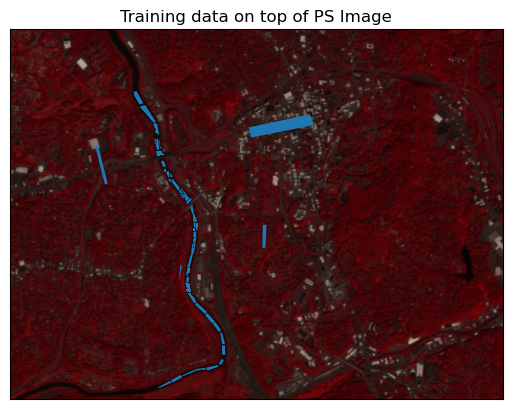

In [5]:
# Plot polygons over raster
import rioxarray as rxr

image = rxr.open_rasterio('./data/20240920_162515_24_24f5_3B_AnalyticMS_SR.tif', masked=True)
clipped_image = image[:, 2250:3750, 6500:8500]
ps_plotting_extent = plotting_extent(clipped_image[0], clipped_image.rio.transform())

# Plot uncropped array
f, ax = plt.subplots()

ep.plot_rgb(clipped_image.values,
            rgb=[3, 2, 1],
            ax=ax,
            title="Training data on top of PS Image",
            extent=ps_plotting_extent) 

shp.plot(ax=ax)

plt.show()

In [6]:
# Extract geometry of each feature in shp in GeoJSON format
geoms = shp.geometry.values

# check one of the geometries
geometry = geoms[0] 
print(type(geometry))
print(geometry)

# transform to GeoJSON format
from shapely.geometry import mapping
feature = [mapping(geometry)] 
print(type(feature))
print(feature)

<class 'shapely.geometry.polygon.Polygon'>
POLYGON ((357933 3938826, 357954 3938826, 357954 3938787, 357939 3938787, 357939 3938793, 357936 3938793, 357936 3938796, 357933 3938796, 357933 3938799, 357930 3938799, 357927 3938799, 357927 3938802, 357927 3938805, 357927 3938817, 357927 3938820, 357927 3938823, 357930 3938823, 357930 3938826, 357933 3938826))
<class 'list'>
[{'type': 'Polygon', 'coordinates': (((357933.0, 3938826.0), (357954.0, 3938826.0), (357954.0, 3938787.0), (357939.0, 3938787.0), (357939.0, 3938793.0), (357936.0, 3938793.0), (357936.0, 3938796.0), (357933.0, 3938796.0), (357933.0, 3938799.0), (357930.0, 3938799.0), (357927.0, 3938799.0), (357927.0, 3938802.0), (357927.0, 3938805.0), (357927.0, 3938817.0), (357927.0, 3938820.0), (357927.0, 3938823.0), (357930.0, 3938823.0), (357930.0, 3938826.0), (357933.0, 3938826.0)),)}]


In [7]:
# extract raster values within the polygon
from rasterio.mask import mask
out_image, out_transform = mask(ps_bands, feature, crop=True)
out_image.shape

(4, 13, 9)

In [8]:
# close rasterio dataset
ps_bands.close()

#### Building Training Data for scikit-learn

In [9]:
# Create array X with all the pixels and arary Y with training indicies
X = np.array([], dtype=np.int8).reshape(0,4) 
y = np.array([], dtype=np.int8) 

In [10]:
# extract raster values within the polygon
with rio.open('./data/20240920_162515_24_24f5_3B_AnalyticMS_SR.tif') as src:
    band_count = src.count
    for index, geom in enumerate(geoms):
        feature = [mapping(geom)]

        # the mask function returns an array of the raster pixels within this feature
        out_image, out_transform = mask(src, feature, crop=True) 
        # eliminate all the pixels with 0 values for all 8 bands (not part of the shapefile)
        out_image_trimmed = out_image[:,~np.all(out_image == 0, axis=0)]
        # eliminate all the pixels with 255 values for all bands (not actually part of the shapefile)
        out_image_trimmed = out_image_trimmed[:,~np.all(out_image_trimmed == 255, axis=0)]
        # reshape the array to [pixel count, bands]
        out_image_reshaped = out_image_trimmed.reshape(-1, band_count)
        # append the labels to the y array
        y = np.append(y,[shp['Class'][index]] * out_image_reshaped.shape[0]) 
        # stack the pixels onto the pixel array
        X = np.vstack((X,out_image_reshaped))

In [11]:
X

array([[ 257,  252,  265,  271],
       [ 269,  253,  239,  229],
       [ 277,  273,  263,  262],
       ...,
       [3971, 3960, 3951, 3678],
       [3920, 3767, 3972, 3894],
       [3945, 3804, 3792, 3806]], dtype=int32)

In [12]:
y
np.unique(y, return_counts=True)

(array([0, 1]), array([14730, 15614]))

In [13]:
# What are our classification indexes?
labels = np.unique(shp['Class'])
print('The training data include {n} classes: {classes}\n'.format(n=labels.size, classes=labels))
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

The training data include 2 classes: [0 1]

Our X matrix is sized: (30344, 4)
Our y array is sized: (30344,)


Training RF classifier

In [14]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# test_size = 0.25 >> i.e. 25% of the data; represents the proportion of the dataset to include in the test split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 8) 

In [15]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (22758, 4)
Training Labels Shape: (22758,)
Testing Features Shape: (7586, 4)
Testing Labels Shape: (7586,)


In [16]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 100, random_state = 8)
# Fit the model on training data
rf.fit(train_features, train_labels)

RandomForestClassifier(random_state=8)

In [17]:
# Clip stack
clipped_ps_stack = ps_stack[:, 2000:4000, 6000:9000]
print(clipped_ps_stack.shape)

(4, 2000, 3000)


In [18]:
from rasterio.plot import reshape_as_image
reshaped_ps_stack = reshape_as_image(clipped_ps_stack)
print(reshaped_ps_stack.shape, type(reshaped_ps_stack))

(2000, 3000, 4) <class 'numpy.ndarray'>


In [19]:
class_prediction = rf.predict(reshaped_ps_stack.reshape(-1,4))

In [20]:
# Reshape our classificaiton map back into a 2D matrix so we can visualize it
class_prediction = class_prediction.reshape(reshaped_ps_stack[:,:,0].shape)

In [21]:
class_prediction
np.unique(class_prediction, return_counts=True)

(array([0, 1]), array([2936496, 3063504]))

In [22]:
class_prediction.shape

(2000, 3000)

In [23]:
# define function to stretch the color for better viz
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rio.plot.adjust_band(colors[:, :, b])
    return colors

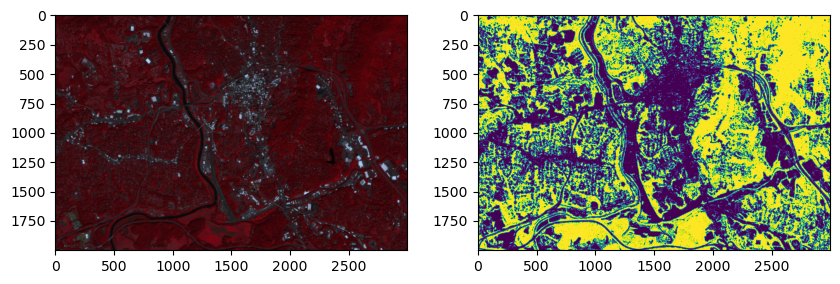

In [24]:
# Let's look at the results
fig, axs = plt.subplots(1,2,figsize=(10,8))

img_stretched = color_stretch(reshaped_ps_stack, [3,2,1])
axs[0].imshow(img_stretched)

axs[1].imshow(class_prediction)